In [8]:
# Needed to install seaborn first, you can probably skip these lines.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pip install seaborn 


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import patsy
# Load the LinearRegression class from scikit-learn's linear_model module
# Also load the PolynomialFeatures transformer and OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder

# Load the stats module from scipy so we can code the functions to compute model statistics
from scipy import stats

# Load StatsModels API
# Note that if we wish to use R-style formulas, then we would load statsmodels.formula.api instead
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [10]:
class ExtendedLinearRegression(LinearRegression):
    
    def detailed_linear_regression(self, X, y):
        """
        Assume X is array-like with shape (num_samples, num_features)
        Assume y is array-like with shape (num_samples, num_targets)
        include_intercept is a boolean where True means X does not already have a column
        for the intercept
        Computes the least-squares regression model and returns a dictionary consisting of
        the fitted linear regression object; a series with the residual standard error,
        R^2 value, and the overall F-statistic with corresponding p-value; and a dataframe
        with columns for the parameters, and their corresponding standard errors,
        t-statistics, and p-values.
        """
        # Create a linear regression object and fit it using x and y
        self.training_X, self.training_y = X, y
        self.fit(X, y)
    
        # Store the parameters (regression intercept (if present) and coefficients) and predictions
        if(self.intercept_ != 0):
            self.params = np.append(self.intercept_, self.coef_)
        else:
            self.params = self.coef_.flatten()
        predictions = self.predict(X)
    
        # Create matrix with shape (num_samples, num_features + 1)
        # Where the first column is all 1s (if there is an intercept) and then there is one column for the values
        # of each feature/predictor
        if(self.intercept_ != 0):
            X_mat = np.append(np.ones((X.shape[0], 1)), X, axis = 1)
        else:
            X_mat = X
    
        # Compute residual sum of squares
        self.RSS = np.sum((y - predictions)**2)
    
        # Compute total sum of squares
        self.TSS = np.sum((np.mean(y) - y)**2)
    
        # Estimate the variance of the y-values
        obs_var = self.RSS/(X_mat.shape[0] - X_mat.shape[1])
    
        # Residual standard error is square root of variance of y-values
        self.RSE = obs_var**0.5
    
        # Variances of the parameter estimates are on the diagonal of the 
        # variance-covariance matrix of the parameter estimates
        self.var_beta_mat = obs_var*(np.linalg.inv(np.matmul(X_mat.T, X_mat)))
        self.var_beta = self.var_beta_mat.diagonal()
    
        # Standard error is square root of variance
        self.se_beta = np.sqrt(self.var_beta)
    
        # t-statistic for beta_i is beta_i/se_i, 
        # where se_i is the standard error for beta_i
        t_stats_beta = self.params/self.se_beta
    
        # Compute p-values for each parameter using a t-distribution with
        # (num_samples - 1) degrees of freedom
        beta_p_values = [2 * (1 - stats.t.cdf(np.abs(t_i), X_mat.shape[0] - 1)) for t_i in t_stats_beta]
    
        # Compute value of overall F-statistic, to measure how likely our
        # coefficient estimate are, assuming there is no relationship between
        # the predictors and the response
        if(self.intercept_ != 0):
            self.F_overall = ((self.TSS - self.RSS)/(X_mat.shape[1] - 1))/(self.RSS/(X_mat.shape[0] - X_mat.shape[1]))
            self.F_p_value = stats.f.sf(self.F_overall, X_mat.shape[1] - 1, X_mat.shape[0] - X_mat.shape[1])
        else:
            self.F_overall = ((self.TSS - self.RSS)/(X_mat.shape[1]))/(self.RSS/(X_mat.shape[0] - X_mat.shape[1]))
            self.F_p_value = stats.f.sf(self.F_overall, X_mat.shape[1], X_mat.shape[0] - X_mat.shape[1])
    
        # Construct dataframe for the overall model statistics:
        # RSE, R^2, F-statistic, p-value for F-statistic
        oa_model_stats = pd.Series({"Residual standard error": self.RSE, "R-squared": self.score(X, y), "F-statistic": self.F_overall, "F-test p-value": self.F_p_value})
    
        # Construct dataframe for parameter statistics:
        # coefficients, standard errors, t-statistic, p-values for t-statistics
        param_stats = pd.DataFrame({"Coefficient": self.params, "Standard Error": self.se_beta, "t-value": t_stats_beta, "Prob(>|t|)": beta_p_values})
        return {"model": self, "param_stats": param_stats, "oa_stats": oa_model_stats}
    
    def param_conf_int(self, level = 0.95):
        """
        Assume level, if given, is a float with 0 < level < 1
        Computes confidence intervals at the given confidence level for each parameter
        in the linear regression model relating the predictors X to the response y
        Returns a dataframe with the endpoints of the confidence interval for each parameter
        """
        conf_intervals = pd.DataFrame()
        # Degrees of freedom = num_samples - (num_features + 1)
        df = self.training_X.shape[0] - (self.training_X.shape[1] + 1)
        a, b = str(round((1 - level)*100/2, 2)) + "%", str(round((1 + level)*100/2, 2)) + "%"
        # Loop through each parameter
        for i in range(len(self.params)):
            coeff = self.params[i]
            std_err = self.se_beta[i]
            # alpha = level of confidence
            # df = degrees of freedom = num_samples - number of parameters
            # loc = center of t-interval = estimated coefficient value
            # scale = standard error in coefficient estimate
            conf_intervals = conf_intervals.append(pd.DataFrame([stats.t.interval(level, df, loc = coeff, scale = std_err)], columns = [a, b]), ignore_index = True)
        return conf_intervals
    
    def predict_intervals(self, X_pred, level = 0.95, kind = "confidence"):
        """
        Assume X_pred is array-like with shape (num_predictions, num_features) with x-values for which we want predictions
        Assume level, if given, is a float with 0 < level < 1
        Assume kind, if given is either the string "confidence" or "prediction" for the kind of interval
        Computes confidence intervals at the given confidence level for each parameter
        in the linear regression model relating the predictors X to the response y
        Returns a dataframe with the endpoints of the confidence interval for each parameter
        """
        # Store predictions for easy access
        predictions = self.predict(X_pred)
        intervals = pd.DataFrame()
        # Degrees of freedom = num_samples - (num_features + 1)
        df = self.training_X.shape[0] - (self.training_X.shape[1] + 1)
        a, b = str(round((1 - level)*100/2, 2)) + "%", str(round((1 + level)*100/2, 2)) + "%"
        # Loop through each x-value being used for prediction
        for i in range(len(predictions)):
            prediction = predictions[i]
            # Need to append the leading 1 since our matrix of regression parameter
            # Estimates has first row the estimate for the constant
            x_star = np.append(np.ones(1), X_pred[i])
            conf_error = np.matmul(np.matmul(x_star.T, self.var_beta_mat), x_star)**0.5
            predict_error = (self.RSE**2 + conf_error**2)**0.5
            # alpha = level of confidence
            # df = degrees of freedom = num_samples - number of parameters
            # loc = center of t-interval = predicted value from linear regression model
            # scale = standard error in predicted value estimate
            if (kind == "confidence"):
                lower, upper = stats.t.interval(level, df, loc = prediction, scale = conf_error)
                intervals = intervals.append(pd.Series({"prediction": prediction[0], a: lower[0], b: upper[0]}), ignore_index = True) 
            elif(kind == "prediction"):
                lower, upper = stats.t.interval(level, df, loc = prediction, scale = predict_error)
                intervals = intervals.append(pd.Series({"prediction": prediction[0], a: lower[0], b: upper[0]}), ignore_index = True)
        return intervals

In [11]:
game_data_filepath = "game_dataset.csv"
game_data = pd.read_csv(game_data_filepath, na_values = ["?"]).dropna()

In [12]:
mod = smf.ols(formula = "Global_Sales ~ Active_Players", data = game_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           Global_Sales   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.09494
Date:                Tue, 04 Mar 2025   Prob (F-statistic):              0.758
Time:                        18:55:33   Log-Likelihood:                -8187.6
No. Observations:                2000   AIC:                         1.638e+04
Df Residuals:                    1998   BIC:                         1.639e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         24.3191      0.661     36.

In [13]:
X = game_data["Active_Players"].values.reshape(-1, 1)
y = game_data["Global_Sales"].values.reshape(-1, 1)
extended_reg = ExtendedLinearRegression()
detailed_regression_stats = extended_reg.detailed_linear_regression(X, y)

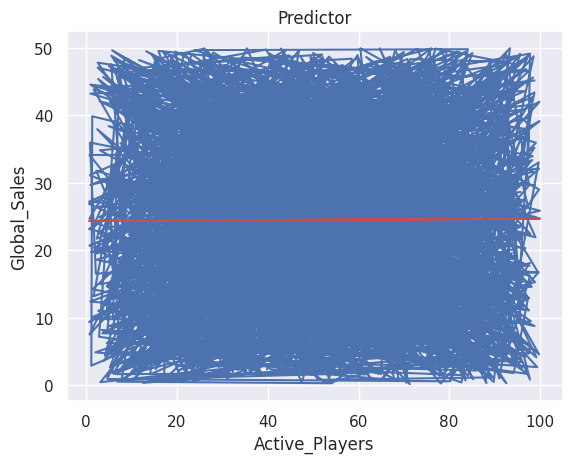

In [14]:
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
plt.plot(X, y, 'b') 
plt.plot(X, y_pred, 'r')
plt.xlabel('Active_Players')
plt.ylabel('Global_Sales')
plt.title('Predictor')
plt.show()